In [1]:
import scipy
from scipy.interpolate import CubicHermiteSpline, PPoly, interp1d
from scipy.integrate import solve_ivp, ode, odeint
import jax
import pickle
import numpy as np
import matplotlib.pyplot as plt

def dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * np.cos(_theta) * np.cos(_theta)

    deriv = np.zeros(4)  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * np.sin(_theta)) + \
        m * m * L * L * np.cos(_theta) * np.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * np.cos(_theta)) * \
        (_a + m * L * _w * _w * np.sin(_theta))+(M + m) * \
        (-m * g * L * np.sin(_theta))) * mass_term
    return deriv

def enforce_bounds(state):
    '''

    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    new_state = np.array(state)
    if state[STATE_V] < MIN_V:
        new_state[STATE_V] = MIN_V
    elif state[STATE_V] > MAX_V:
        new_state[STATE_V] = MAX_V

    if state[STATE_THETA] < -np.pi:
        new_state[STATE_THETA] += 2*np.pi
    elif state[STATE_THETA] > np.pi:
        new_state[STATE_THETA] -= 2*np.pi

    if state[STATE_W] < MIN_W:
        new_state[STATE_W] = MIN_W
    elif state[STATE_W] > MAX_W:
        new_state[STATE_W] = MAX_W
    return new_state



def jax_dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.cos(_theta)

    deriv = np.zeros(4)  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta)) + \
        m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * jax.numpy.cos(_theta)) * \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta))+(M + m) * \
        (-m * g * L * jax.numpy.sin(_theta))) * mass_term
    return deriv


def true_linear(x, u):
    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi
    MIN_W, MAX_W = -7., 7

    MIN_TORQUE, MAX_TORQUE = -1., 1.

    LENGTH = 1.
    MASS = 1.
    DAMPING = .05
    gravity_coeff = MASS*9.81*LENGTH*0.5
    integration_coeff = 3. / (MASS*LENGTH*LENGTH)
    A = np.zeros((2,2))
    A[0,0] = 0
    A[0,1] = 1.
    A[1,0] = integration_coeff*gravity_coeff*np.sin(x[0])
    A[1,1] = -integration_coeff*DAMPING
    B = np.zeros((2,1))
    B[0,0] = 0
    B[1,0] = integration_coeff
    return A,B
 


def jaxfunc(x, u):
    return jax.numpy.asarray(jax_dynamics(x, u))

def linearization(x, u):
    A = jax.jacfwd(jaxfunc, argnums=0)(x, u)
    B = jax.jacfwd(jaxfunc, argnums=1)(x, u)
    return A, B
    

# see if the linearization is working fine
direction = np.random.normal(size=5)
direction = direction / np.linalg.norm(direction)
epsilon = np.linspace(-1, 1, 100)

x = np.array([0.,0.,0.,0.])
u = np.array([0.])
state = np.array([x[0], x[1], x[2], x[3], u[0]])
# linearlize around this point
approx_error = []
for i in range(len(epsilon)):
    new_state = direction * epsilon[i] + state
    new_x = new_state[:4]
    new_u = np.array([new_state[4]])
    true_dx = dynamics(new_x, new_u)
    A, B = linearization(x, u)
    approx_dx = dynamics(x, u) + A @ (new_x - x) + B @ (new_u - u)
    approx_error.append(np.linalg.norm(approx_dx - true_dx))
plt.plot(epsilon, approx_error)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# plotting the lyapunov verification region
from python_lyapunov_test import *
# read the data obtained from sparse_rrt

def dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * np.cos(_theta) * np.cos(_theta)

    deriv = np.zeros(4)  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    # normalize: added (1/max_X) term
    #deriv[STATE_V] = (1/MAX_X)*((I + m * L * L)* \
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * np.sin(_theta)) + \
        m * m * L * L * np.cos(_theta) * np.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * np.cos(_theta)) * \
        (_a + m * L * _w * _w * np.sin(_theta))+(M + m) * \
        (-m * g * L * np.sin(_theta))) * mass_term
    return deriv

def enforce_bounds(state):
    '''

    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    new_state = np.array(state)
    """
    if state[STATE_V] < MIN_V/30.:
        new_state[STATE_V] = MIN_V/30.
    elif state[STATE_V] > MAX_V/30.:
        new_state[STATE_V] = MAX_V/30.
    """
    if state[STATE_V] < MIN_V:
        new_state[STATE_V] = MIN_V
    elif state[STATE_V] > MAX_V:
        new_state[STATE_V] = MAX_V

    if state[STATE_THETA] < -np.pi:
        new_state[STATE_THETA] += 2*np.pi
    elif state[STATE_THETA] > np.pi:
        new_state[STATE_THETA] -= 2*np.pi

    if state[STATE_W] < MIN_W:
        new_state[STATE_W] = MIN_W
    elif state[STATE_W] > MAX_W:
        new_state[STATE_W] = MAX_W
    return new_state



def jax_dynamics(state, control):
    '''
    implement the function x_dot = f(x,u)
    return the derivative w.r.t. x
    '''
    I = 10
    L = 2.5
    M = 10
    m = 5
    g = 9.8
    H = 0.5  # cart
    # define the name for each state index and action index
    STATE_X, STATE_V, STATE_THETA, STATE_W = 0, 1, 2, 3
    CONTROL_A = 0
    # define boundary
    MIN_X = -30
    MAX_X = 30
    MIN_V = -40
    MAX_V = 40
    MIN_W = -2
    MAX_W = 2
    # obstacle information
    OBS_W = 4
    _v = state[STATE_V]
    _w = state[STATE_W]
    _theta = state[STATE_THETA]
    _a = control[CONTROL_A]
    mass_term = (M + m)*(I + m * L * L) - \
            m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.cos(_theta)

    deriv = [0,0,0,0]  # init derivative
    deriv[STATE_X] = _v
    deriv[STATE_THETA] = _w
    mass_term = (1.0 / mass_term)
    # normalize (added 1/max_X term)
    #deriv[STATE_V] = (1/MAX_X)*((I + m * L * L)* \
    deriv[STATE_V] = ((I + m * L * L)* \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta)) + \
        m * m * L * L * jax.numpy.cos(_theta) * jax.numpy.sin(_theta) * g) * mass_term
    deriv[STATE_W] = ((-m * L * jax.numpy.cos(_theta)) * \
        (_a + m * L * _w * _w * jax.numpy.sin(_theta))+(M + m) * \
        (-m * g * L * jax.numpy.sin(_theta))) * mass_term
    return jax.numpy.asarray(deriv)


In [3]:




f = open('../../data/cartpole/0/path_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
for i in range(len(x)):
    x[i][0] = x[i][0]
    x[i][1] = x[i][1]  # normalize state and velocity
f = open('../../data/cartpole/0/control_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/cartpole/0/cost_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
"""
# cartpole
f = open('../../data/cartpole/0/path_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
x = p.load()
f = open('../../data/cartpole/0/control_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
u = p.load()
u = u.reshape(len(u),1)
f = open('../../data/cartpole/0/cost_1.pkl', 'rb')
p = pickle._Unpickler(f)
p.encoding = 'latin1'
dt = p.load()
goal = x[-1]
#goal = sg[-1]
"""


new_x = []
new_u = []
new_dt = []
new_x0 = x[0]
new_x.append(new_x0)
# what if we only look at the first segment

x0 = x[0]
xT = x[-1]
print('previous xT:')
print(xT)

for i in range(len(dt)):
    for j in range(int(dt[i]/0.02)):
        new_x0 = new_x0 + 0.02*dynamics(new_x0, u[i])
        new_x0 = enforce_bounds(new_x0)
        #new_x.append(new_x0)
        #new_u.append(u[i])
        #new_dt.append(0.02)
    new_x.append(new_x0)
    new_u.append(u[i])
    new_dt.append(dt[i])
x = new_x
u = new_u
dt = new_dt
goal = x[-1]

time_knot = np.cumsum(new_dt)
time_knot = np.insert(time_knot, 0, 0.)
print(time_knot)
# obtain a lqr for end position
#A = jax.jacfwd(jaxfunc, argnums=0)(xtraj(time_knot[-1]), utraj(time_knot[-1]))
#B = jax.jacfwd(jaxfunc, argnums=1)(xtraj(time_knot[-1]), utraj(time_knot[-1]))

controller, xtraj, utraj, S = tvlqr(x, u, dt, dynamics, jax_dynamics)


previous xT:
[19.20814521 -0.93980455  1.41688864 -0.93997791]
[ 0.     0.072  0.236  0.512  1.14   2.072  3.238  4.552  5.918  7.232
  8.398  9.33   9.958 10.234 10.862 11.794 12.96  13.236 13.864 14.796
 14.906 15.158 15.53 ]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]


In [4]:
#print(x)
#x = np.array(x)


#indices = np.arange(0, len(time_knot), 10)
#time_knot = time_knot[indices]
#print(time_knot)

In [5]:
#time_knot = np.append(time_knot, np.sum(new_dt))
# including the end index
#print(time_knot)

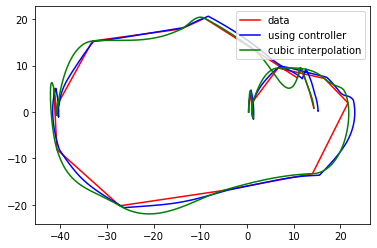

In [6]:
x = np.array(x)
plt.plot(x[:,0], x[:,1], 'r', label='data')

#num = 200
num = np.sum(dt) / 0.02
time_span = np.linspace(0, np.sum(dt), num+1)
delta_t = time_span[-1] / num
actual_x = np.array(x0)
xs = []
xs.append(actual_x)
real_xs = []
# plot data
for i in range(len(time_span)):
    u = controller(time_span[i], actual_x)
    #print('current state:')
    #print(x)
    #print('tracked traj:')
    #print(x_traj(time_span[i]))
    xdot = dynamics(actual_x, u)
    actual_x = actual_x + xdot * delta_t
    xs.append(actual_x)
    real_xs.append(xtraj(time_span[i]))
    actual_x = enforce_bounds(actual_x)
xs = np.array(xs)
real_xs = np.array(real_xs)
#print(xs)
#print(real_xs)
plt.plot(xs[:,0], xs[:,1], 'b', label='using controller')
plt.plot(real_xs[:,0], real_xs[:,1], 'g', label='cubic interpolation')
plt.legend()

In [7]:
xG = np.array(goal)
uG = np.zeros((1))
uG = np.array([0.])
#uG = stable_u(xG)
print(dynamics(xG, uG))
A = jax.jacfwd(jax_dynamics, argnums=0)(xG, uG)
B = jax.jacfwd(jax_dynamics, argnums=1)(xG, uG)

A = np.asarray(A)
B = np.asarray(B)
Q = np.identity(len(x[0]))
R = np.identity(len(uG))
K, lqr_S, E = control.lqr(A, B, Q, R)

#print(dynamics(xtraj(time_knot[-1]), utraj(time_knot[-1])))
lqr_rho = sample_ti_verify(xG, uG, lqr_S, K, dynamics, numSample=1000)
# create a funnel that guides
upper_rho = lqr_rho
upper_x = xG
upper_S = np.identity(len(lqr_S))
lqr_S = np.identity(len(lqr_S))
# in cartpole problem, we may not be able to stablize around the endpoint, set it to a large value
upper_rho = 1.5
tvlqr_rhos = []
print(len(time_knot))

for i in range(len(time_knot)-1,0,-1):
    print('knot %d' % (i))
    t0 = time_knot[i-1]
    t1 = time_knot[i]
    x0 = xtraj(t0)
    u0 = utraj(t0)
    x1 = xtraj(t1)
    u1 = utraj(t1)
    A0 = jax.jacfwd(jax_dynamics, argnums=0)(x0, u0)
    B0 = jax.jacfwd(jax_dynamics, argnums=1)(x0, u0)
    A1 = jax.jacfwd(jax_dynamics, argnums=0)(x1, u1)
    B1 = jax.jacfwd(jax_dynamics, argnums=1)(x1, u1)
    A0 = np.asarray(A0)
    B0 = np.asarray(B0)
    A1 = np.asarray(A1)
    B1 = np.asarray(B1)

    S0 = S(t0).reshape(len(x0),len(x0))
    S1 = S(t1).reshape(len(x0),len(x0))
    
    rho0, rhodot0, rho1, rhodot1 = sample_tv_verify_cubic_doubleside(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)
    #rho0, rhodot0, rho1, rhodot1 = sample_tv_verify_cubic_doubleside_num(t0, t1, upper_x, upper_S, upper_rho, S, R, Q, x=xtraj, u=utraj, func=dynamics, jax_func=jax_dynamics, numSample=1000)
    #rho0, rhodot0, rho1, rhodot1 = sample_tv_verify_cubic_num(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)
    #rho0, rho1 = sample_tv_verify_num(t0, t1, upper_x, upper_S, upper_rho, S0, S1, A0, A1, B0, B1, R, Q, x0, x1, u0, u1, dynamics, numSample=1000)

    upper_rho = rho0
    upper_x = x0
    upper_S = S0
    tvlqr_rhos.append([rho0, rhodot0, rho1, rhodot1, t0, t1])
    #tvlqr_rhos.append([rho0, rho1, t0, t1])
    
    


[ 0.80757399  1.74541966 -1.19350874 -3.01065314]
rho: 
1e-06
23
knot 22
max_lower_bound0: 1.982189
max_lower_bound1: 1.841788
rhodot: 2.016128
max_lower_bound0: 1.982189
max_lower_bound1: 1.634936
rhodot: 2.016128
max_lower_bound0: 1.982189
max_lower_bound1: 1.436891
rhodot: 3.024192
max_lower_bound0: 1.982189
max_lower_bound1: 1.248258
rhodot: 4.032255
max_lower_bound0: 1.982189
max_lower_bound1: 1.069637
rhodot: 5.040319
max_lower_bound0: 1.982189
max_lower_bound1: 0.901626
rhodot: 6.048383
max_lower_bound0: 1.982189
max_lower_bound1: 0.744813
rhodot: 7.056447
max_lower_bound0: 1.982189
max_lower_bound1: 0.599779
rhodot: 8.064511
max_lower_bound0: 1.982189
max_lower_bound1: 0.467097
rhodot: 9.072575
max_lower_bound0: 1.982189
max_lower_bound1: 0.347330
rhodot: 10.080638
max_lower_bound0: 1.982189
max_lower_bound1: 0.241034
rhodot: 11.088702
max_lower_bound0: 1.982189
max_lower_bound1: 0.148762
rhodot: 12.096766
max_lower_bound0: 1.982189
max_lower_bound1: 0.071069
rhodot: 13.104830


max_lower_bound0: 0.544916
max_lower_bound1: 0.067284
rhodot: 9.821416
max_lower_bound0: 0.544916
max_lower_bound1: 0.047658
rhodot: 10.714272
max_lower_bound0: 0.544916
max_lower_bound1: 0.030371
rhodot: 11.607128
max_lower_bound0: 0.544916
max_lower_bound1: 0.015776
rhodot: 12.499984
max_lower_bound0: 0.544916
max_lower_bound1: 0.004342
rhodot: 13.392840
max_lower_bound0: 0.544916
max_lower_bound1: -0.003239
rhodot: 14.285696
max_lower_bound0: 0.544916
max_lower_bound1: -0.005781
rhodot: 15.178553
max_lower_bound0: 0.544916
max_lower_bound1: -0.000000
rhodot: 16.071409
max_lower_bound0: 0.445082
max_lower_bound1: 0.688676
rhodot: 3.571429
max_lower_bound0: 0.445082
max_lower_bound1: 0.615638
rhodot: 3.571429
max_lower_bound0: 0.445082
max_lower_bound1: 0.545938
rhodot: 3.571429
max_lower_bound0: 0.445082
max_lower_bound1: 0.479648
rhodot: 3.571429
max_lower_bound0: 0.445082
max_lower_bound1: 0.416849
rhodot: 3.571429
max_lower_bound0: 0.445082
max_lower_bound1: 0.357626
rhodot: 3.571

max_lower_bound0: 0.111575
max_lower_bound1: 0.195484
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.178215
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.161478
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.145296
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.129693
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.114696
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.100334
rhodot: 0.540773
max_lower_bound0: 0.111575
max_lower_bound1: 0.086641
rhodot: 0.675963
max_lower_bound0: 0.111575
max_lower_bound1: 0.073654
rhodot: 0.811156
max_lower_bound0: 0.111575
max_lower_bound1: 0.061417
rhodot: 0.946349
max_lower_bound0: 0.111575
max_lower_bound1: 0.049978
rhodot: 1.081542
max_lower_bound0: 0.111575
max_lower_bound1: 0.039398
rhodot: 1.216735
max_lower_bound0: 0.111575
max_lower_bound1: 0.029746
rhodot: 1.351928
max_lower_bound0: 0.111575
max_lower_bound1: 0.021110
rhodot: 1.487120
max_lo

max_lower_bound0: 0.001924
max_lower_bound1: 0.006442
rhodot: 0.420142
max_lower_bound0: 0.001924
max_lower_bound1: 0.005092
rhodot: 0.466825
max_lower_bound0: 0.001924
max_lower_bound1: 0.003852
rhodot: 0.513507
max_lower_bound0: 0.001924
max_lower_bound1: 0.002729
rhodot: 0.560190
max_lower_bound0: 0.001924
max_lower_bound1: 0.001732
rhodot: 0.606872
max_lower_bound0: 0.001924
max_lower_bound1: 0.000874
rhodot: 0.653554
max_lower_bound0: 0.001924
max_lower_bound1: 0.000167
rhodot: 0.700237
max_lower_bound0: 0.001924
max_lower_bound1: -0.000370
rhodot: 0.746919
max_lower_bound0: 0.001924
max_lower_bound1: -0.000713
rhodot: 0.793602
max_lower_bound0: 0.001924
max_lower_bound1: -0.000796
rhodot: 0.840284
max_lower_bound0: 0.001924
max_lower_bound1: -0.000600
rhodot: 0.886967
max_lower_bound0: 0.001924
max_lower_bound1: -0.000000
rhodot: 0.933649
max_lower_bound0: 0.001080
max_lower_bound1: 0.020505
rhodot: 0.093365
max_lower_bound0: 0.001080
max_lower_bound1: 0.018470
rhodot: 0.093365
m

max_lower_bound0: 0.007670
max_lower_bound1: -0.000098
rhodot: 0.943018
max_lower_bound0: 0.007670
max_lower_bound1: -0.000000
rhodot: 0.998490
max_lower_bound0: 0.005418
max_lower_bound1: 0.021488
rhodot: 0.221888
valid rho1 found. Advance to the next rho0...
rho0 = 0.111477, rho1 = 0.132379
rho0:
0.11147673600000002
rho1:
0.132378674
knot 13
max_lower_bound0: 0.090377
max_lower_bound1: 0.003321
rhodot: 0.100974
max_lower_bound0: 0.090377
max_lower_bound1: 0.002627
rhodot: 0.201949
max_lower_bound0: 0.090377
max_lower_bound1: 0.001975
rhodot: 0.302923
max_lower_bound0: 0.090377
max_lower_bound1: 0.001366
rhodot: 0.403898
max_lower_bound0: 0.090377
max_lower_bound1: 0.000803
rhodot: 0.504872
max_lower_bound0: 0.090377
max_lower_bound1: 0.000287
rhodot: 0.605846
max_lower_bound0: 0.090377
max_lower_bound1: -0.000180
rhodot: 0.706821
max_lower_bound0: 0.090377
max_lower_bound1: -0.000597
rhodot: 0.807795
max_lower_bound0: 0.090377
max_lower_bound1: -0.000960
rhodot: 0.908770
max_lower_bo

max_lower_bound0: -0.001587
max_lower_bound1: 0.001504
rhodot: 0.041301
max_lower_bound0: -0.001587
max_lower_bound1: 0.001171
rhodot: 0.055068
max_lower_bound0: -0.001587
max_lower_bound1: 0.000861
rhodot: 0.068835
max_lower_bound0: -0.001587
max_lower_bound1: 0.000574
rhodot: 0.082602
max_lower_bound0: -0.001587
max_lower_bound1: 0.000405
rhodot: 0.096369
max_lower_bound0: -0.001587
max_lower_bound1: 0.000270
rhodot: 0.110137
max_lower_bound0: -0.001587
max_lower_bound1: 0.000162
rhodot: 0.123904
max_lower_bound0: -0.001587
max_lower_bound1: 0.000110
rhodot: 0.137671
max_lower_bound0: -0.001587
max_lower_bound1: 0.000064
rhodot: 0.151438
max_lower_bound0: -0.001587
max_lower_bound1: 0.000024
rhodot: 0.165205
max_lower_bound0: -0.001587
max_lower_bound1: -0.000010
rhodot: 0.178972
max_lower_bound0: -0.001587
max_lower_bound1: -0.000036
rhodot: 0.192739
max_lower_bound0: -0.001587
max_lower_bound1: -0.000056
rhodot: 0.206506
max_lower_bound0: -0.001587
max_lower_bound1: -0.000067
rhodo

max_lower_bound0: -0.000085
max_lower_bound1: 0.001632
rhodot: 0.048173
max_lower_bound0: -0.000085
max_lower_bound1: 0.001409
rhodot: 0.056202
max_lower_bound0: -0.000085
max_lower_bound1: 0.001199
rhodot: 0.064231
max_lower_bound0: -0.000085
max_lower_bound1: 0.001001
rhodot: 0.072260
max_lower_bound0: -0.000085
max_lower_bound1: 0.000817
rhodot: 0.080289
max_lower_bound0: -0.000085
max_lower_bound1: 0.000648
rhodot: 0.088318
max_lower_bound0: -0.000085
max_lower_bound1: 0.000493
rhodot: 0.096346
max_lower_bound0: -0.000085
max_lower_bound1: 0.000354
rhodot: 0.104375
max_lower_bound0: -0.000085
max_lower_bound1: 0.000259
rhodot: 0.112404
max_lower_bound0: -0.000085
max_lower_bound1: 0.000177
rhodot: 0.120433
max_lower_bound0: -0.000085
max_lower_bound1: 0.000107
rhodot: 0.128462
max_lower_bound0: -0.000085
max_lower_bound1: 0.000050
rhodot: 0.136491
max_lower_bound0: -0.000085
max_lower_bound1: 0.000010
rhodot: 0.144520
max_lower_bound0: -0.000085
max_lower_bound1: -0.000007
rhodot: 

max_lower_bound0: 0.000032
max_lower_bound1: -0.000036
rhodot: 0.460655
max_lower_bound0: 0.000032
max_lower_bound1: -0.000035
rhodot: 0.537431
max_lower_bound0: 0.000032
max_lower_bound1: -0.000034
rhodot: 0.614207
max_lower_bound0: 0.000032
max_lower_bound1: -0.000033
rhodot: 0.690983
max_lower_bound0: 0.000032
max_lower_bound1: -0.000032
rhodot: 0.767759
max_lower_bound0: 0.000032
max_lower_bound1: -0.000030
rhodot: 0.844534
max_lower_bound0: 0.000032
max_lower_bound1: -0.000028
rhodot: 0.921310
max_lower_bound0: 0.000032
max_lower_bound1: -0.000026
rhodot: 0.998086
max_lower_bound0: 0.000032
max_lower_bound1: -0.000023
rhodot: 1.074862
max_lower_bound0: 0.000032
max_lower_bound1: -0.000020
rhodot: 1.151638
max_lower_bound0: 0.000032
max_lower_bound1: -0.000017
rhodot: 1.228414
max_lower_bound0: 0.000032
max_lower_bound1: -0.000014
rhodot: 1.305190
max_lower_bound0: 0.000032
max_lower_bound1: -0.000009
rhodot: 1.381965
max_lower_bound0: 0.000032
max_lower_bound1: -0.000005
rhodot: 1

In [8]:
print(time_knot)
print(xtraj(0))
print(x[0])

[ 0.     0.072  0.236  0.512  1.14   2.072  3.238  4.552  5.918  7.232
  8.398  9.33   9.958 10.234 10.862 11.794 12.96  13.236 13.864 14.796
 14.906 15.158 15.53 ]
[ 0.33170833  0.         -1.51299733  0.        ]
[ 0.33170833  0.         -1.51299733  0.        ]


15.158000000000001
15.199333333333335
15.240666666666668
15.282000000000002
15.323333333333334
15.364666666666668
15.406
15.447333333333335
15.488666666666667
15.530000000000001
14.906
14.934000000000001
14.962000000000002
14.99
15.018
15.046000000000001
15.074000000000002
15.102
15.13
15.158000000000001
14.796000000000001
14.808222222222224
14.820444444444446
14.832666666666668
14.84488888888889
14.857111111111111
14.869333333333334
14.881555555555556
14.893777777777778
14.906
13.864
13.967555555555556
14.071111111111112
14.174666666666667
14.278222222222222
14.38177777777778
14.485333333333335
14.58888888888889
14.692444444444446
14.796000000000001
13.236
13.305777777777779
13.375555555555556
13.445333333333334
13.515111111111112
13.584888888888889
13.654666666666667
13.724444444444446
13.794222222222222
13.864
12.96
12.990666666666668
13.021333333333335
13.052000000000001
13.082666666666668
13.113333333333333
13.144
13.174666666666667
13.205333333333334
13.236
11.794
11.923555555555

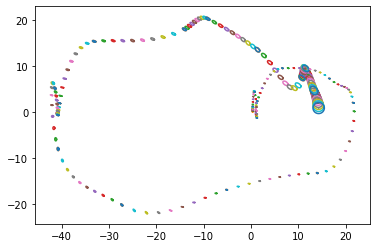

In [9]:
from scipy.interpolate import CubicHermiteSpline
# plot lqr_rho
# sampling points in the epplisolid (x-xG)TS(x-xG)=rho

def plot_ellipsoid(S, rho, x0, alpha=1.0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta), np.zeros(100), np.zeros(100)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = np.sqrt(rho)*X + x0
    plt.plot(X[:,0],X[:,1], alpha=alpha)

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    #rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    #rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        rho_t = rho_cubic(plot_t)
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



In [ ]:

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
#rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    #print(xs)
    #print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

plot_ellipsoid(lqr_S, lqr_rho, xG)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    #rho0, rho1, t0, t1 = tvlqr_rhos[j]
    rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    #rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        rho_t = rho_cubic(plot_t)
        #rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t)



t0:
0.0
0-th sample
num: 776
1-th sample
num: 776
2-th sample
num: 776
3-th sample
num: 776


In [ ]:
def plot_ellipsoid(S, rho, x0, alpha=1.0):
    theta = np.linspace(0, np.pi*2, 100)
    U = [np.cos(theta), np.sin(theta), np.zeros(100), np.zeros(100)]
    U = np.array(U).T
    tmp = np.linalg.pinv(S)
    tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
    S_invsqrt = scipy.linalg.sqrtm(tmp)
    X = U @ S_invsqrt  # 100x2
    X = np.sqrt(rho)*X + x0
    plt.plot(X[:,0],X[:,1], alpha=alpha)


In [ ]:

plot_ellipsoid(lqr_S, lqr_rho, xG, alpha=0.1)
    
# plot funnel
# rho_t = rho0+(rho1-rho0)/(t1-t0)*t
for j in range(len(tvlqr_rhos)):
    rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[j]
    #rho0, rho1, t0, t1 = tvlqr_rhos[j]
    plot_ts = np.linspace(t0, t1, 10)
    # interpolate using cubic hermite
    rho_cubic = CubicHermiteSpline(x=[t0,t1], y=[rho0, rho1], dydx=[rhodot0, rhodot1])
    #rho_ts = rho0+(rho1-rho0)/(t1-t0)*(plot_ts-t0)
    for i in range(len(plot_ts)):
        #rho_t = rho_ts[i]
        
        plot_t = plot_ts[i]
        rho_t = rho_cubic(plot_t)
        #rho_t = rho_ts[i]
        print(plot_t)
        S_t = S(plot_t).reshape(len(x0),len(x0))
        x_t = xtraj(plot_t)
        u_t = utraj(plot_t)
        # plot
        plot_ellipsoid(S_t, rho_t, x_t, alpha=0.1)

# here we test by randomly sample different pertubation to the starting point to see if tvlqr is working
rho0, rhodot0, rho1, rhodot1, t0, t1 = tvlqr_rhos[-1]
#rho0, rho1, t0, t1 = tvlqr_rhos[-1]

print('t0:')
print(t0)
S0 = S(0.).reshape(len(x[0]),len(x[0]))
numSample = 10
U = np.random.normal(loc=0.0, scale=1.0, size=(numSample,len(S0)))
# individually normalize each sample
U = U / np.linalg.norm(U, axis=1, keepdims=True)
for i in range(len(U)):
    alpha = np.random.uniform()
    U[i] = U[i] * alpha
tmp = np.linalg.pinv(S0)
tmp = scipy.linalg.sqrtm(tmp.T @ tmp)
U0 = U@scipy.linalg.sqrtm(tmp)
X0 = np.sqrt(rho0)*U0 + x[0] # 100x2

for k in range(numSample):
    print('%d-th sample' % (k))
    num = np.sum(dt)/0.02
    print('num: %d' % (num))
    time_span = np.linspace(0, np.sum(dt), num+1)
    delta_t = time_span[-1] / num
    actual_x = np.array(X0[k])
    xs = []
    xs.append(actual_x)
    # plot data
    for i in range(len(time_span)):
        u = controller(time_span[i], actual_x)
        #print('current state:')
        #print(x)
        #print('tracked traj:')
        #print(x_traj(time_span[i]))
        xdot = dynamics(actual_x, u)
        actual_x = actual_x + xdot * delta_t
        xs.append(actual_x)
        actual_x = enforce_bounds(actual_x)
    xs = np.array(xs)
    print(xs)
    print(real_xs)
    plt.plot(xs[:,0], xs[:,1], 'black', label='using controller')

